In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [2]:
import warnings
warnings.filterwarnings("ignore")

import utils as u
from importlib import reload
# to reload utils, run:
u = reload(u)

import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.colors import to_hex
from matplotlib.colors import ListedColormap
import mplcursors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path

import webbrowser

warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [4]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

XES_DATA = u.get_Data(Listdir, mode='xes')
XANES_DATA = u.get_Data(Listdir, mode='xanes')

# CIDS = np.array(u.get_Property(XES_DATA, 'CID'))
# compoundtypes = u.get_Property(XES_DATA, 'Type')
# compoundclasses = u.get_Property(XES_DATA, 'Class')

CIDS = np.array(u.get_Property(XES_DATA, 'CID', applyfilter=u.exclude_None_class))
compoundtypes = u.get_Property(XES_DATA, 'Type', applyfilter=u.exclude_None_class)
compoundclasses = u.get_Property(XES_DATA, 'Class', applyfilter=u.exclude_None_class)

In [5]:
CIDS.shape

(576,)

# Visualization of Classification Distributions

In [6]:
Colors = list(plt.cm.viridis(np.arange(1,12)/11))

# type 1
Colors[0] = '#440154'

# type 2
Colors[1] = '#77b6fe'
Colors[2] = '#03506F'

# type 3
Colors[3] = '#ffba93'
Colors[4] = '#DB6400'

# type 4
Colors[5] = '#54bf58'
Colors[6] = '#355E3B'

# type 5
Colors[7] = '#AA524E'
Colors[8] = '#E17C7B'
Colors[9] = '#9F5F80'
# '#e4ce0c'

# type 6
Colors[10] = '#fde725'

CMAP = ListedColormap(Colors)

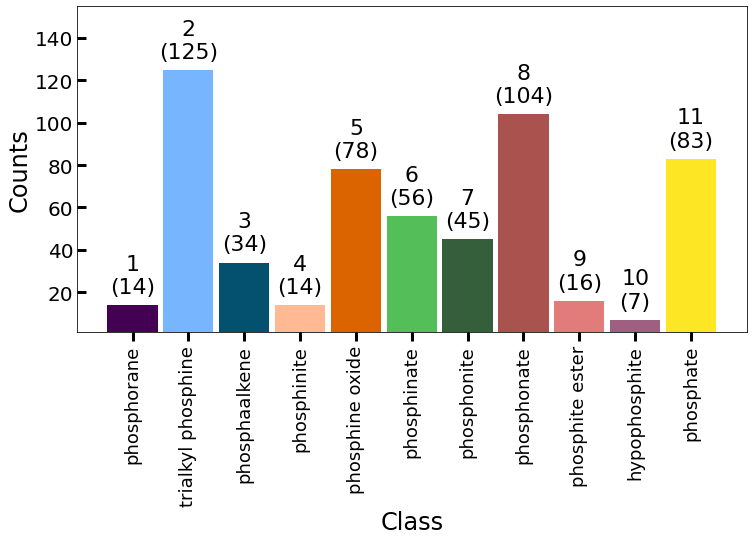

In [7]:
categorizer = compoundclasses

classnames = list(u.TYPE_DICT.keys())[:-1]
bins = [np.sum(np.array(categorizer)==classname) for classname in classnames]

def hist(bins, classnames, label='Category', verbose=False):
    x = classnames
    x_pos = np.array([i for i, _ in enumerate(x)])

    n = len(bins)
    if label == 'Type':
        cmap = plt.cm.viridis
    else:
        cmap = CMAP
    
    Colors = cmap(np.arange(n)/(n-1))

    fig, ax = plt.subplots(figsize=(12,6))

    width=0.9
    bars = ax.bar(x_pos, bins, width=width, color=Colors)
    
    if verbose:
        max_h = 0
        for i,bar in enumerate(bars.patches):
            ax.annotate(f'{i+1}\n({bar.get_height()})', 
                        (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='bottom',
                        size=22, xytext=(0, 8),
                        textcoords='offset points')
            if max_h < bar.get_height():
                max_h = bar.get_height()

    plt.yticks(fontsize=22)
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    plt.xticks(x_pos, x, fontsize=22)

    ax.set_ylabel('Counts', fontsize=24)
    ax.set_xlabel(label, fontsize=24)

    ax.tick_params(axis='y', direction='in', width=3, length=9)
    
    if label=='Type':
        ax.tick_params(axis='x',direction='out', width=3, length=9, labelrotation=0)
        size=24
        if verbose: plt.ylim(1,max_h + 25)
    else:
        ax.tick_params(axis='x',direction='out', width=3, length=9, labelrotation=90)
        size=18
        if verbose: plt.ylim(1,max_h + 30)

    plt.setp(ax.get_xticklabels(), Fontsize=size)
    plt.setp(ax.get_yticklabels(), Fontsize=20)

    plt.show()
    
hist(bins, [c.replace('_', ' ') for c in classnames], label='Class', verbose=True)

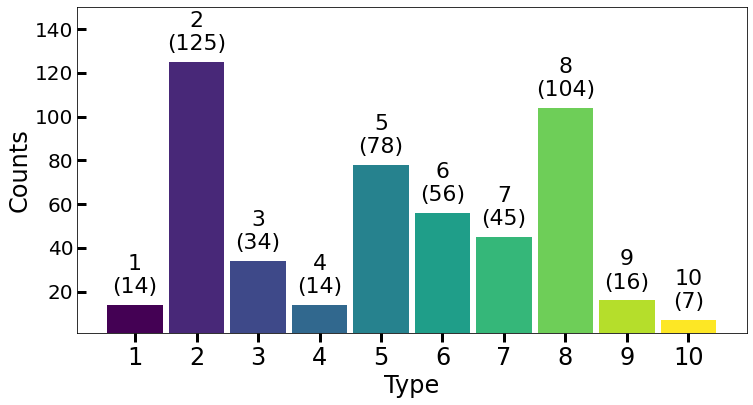

In [8]:
categorizer = compoundtypes

classnames = np.unique(list(u.TYPE_DICT.values()))[:-1]
bins = [np.sum(np.array(categorizer)==classname) for classname in classnames]

hist(bins, classnames, label='Type', verbose=True)

In [9]:
num = 0
for i, Type in enumerate(compoundtypes):
    if Type==6:
        print(CIDS[i])
        num += 1
    if num == 10:
        break

114256
38334
15158
114261
312437
23415768
205862
97571
185489
104467


In [10]:
xes = np.array(u.get_Property(XES_DATA, 'Spectra', applyfilter=u.exclude_None_class))
# xes = np.array(u.get_Property(XES_DATA, 'Spectra'))
XESenergy = xes[0,0,:]
XES = xes[:,1,:]

XES_SCALING = np.max(XES)
XES = XES / XES_SCALING

In [11]:
xanes = np.array(u.get_Property(XANES_DATA, 'Spectra', applyfilter=u.exclude_None_class))
# xanes = np.array(u.get_Property(XANES_DATA, 'Spectra'))
XANESenergy = xanes[0,0,:]
XANES = xanes[:,1,:]

XANES_SCALING = np.max(XANES)
XANES = XANES / XANES_SCALING

### Check calulcations

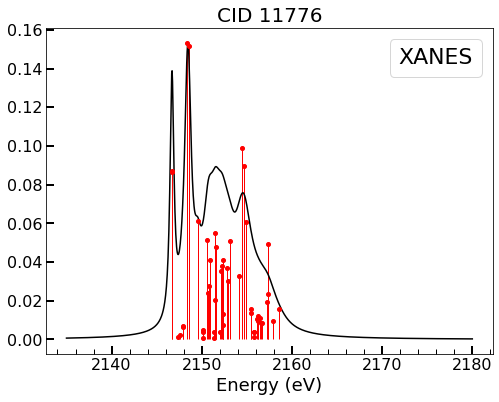

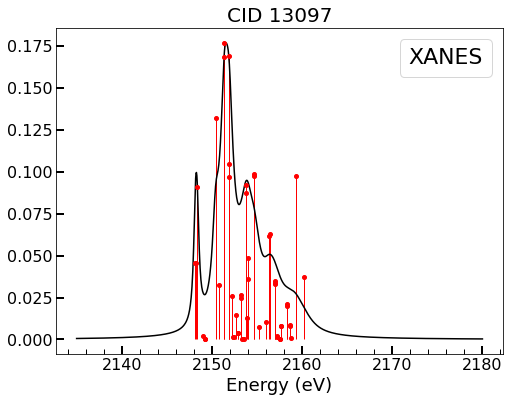

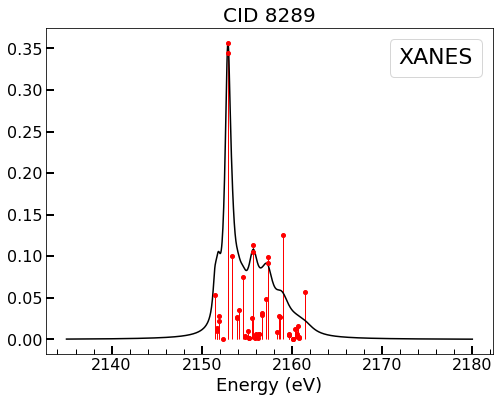

In [12]:
mycids = [11776, 13097, 8289]
all_CIDS = np.array(u.get_Property(XES_DATA, 'CID'))
for cid in mycids:
    
    i = np.where(all_CIDS==cid)[0][0]
    j = np.where(CIDS==cid)[0][0]
    
#     trans = XES_DATA[i]['Transitions']
#     trans = esnip(trans, XES[i], mode='xes', emin=2100)
#     u.plot_spectrum_and_trans([XESenergy, XES[i]], trans, f'{CIDS[i]}', label='VtC-XES')
    
    trans = XANES_DATA[i]['Transitions']
    trans = u.esnip(trans, XANES[j], energy=XANESenergy, mode='xanes')
    u.plot_spectrum_and_trans([XANESenergy, XANES[j]], trans, f'{CIDS[j]}', label='XANES')

#     u.plot_spectrum([XESenergy, XES[i]], f'{CIDS[i]}', label='VtC-XES')
#     u.plot_spectrum([XANESenergy, XANES[i]], f'{CIDS[i]}', label='XANES')


# Theory and Experiment Comparison

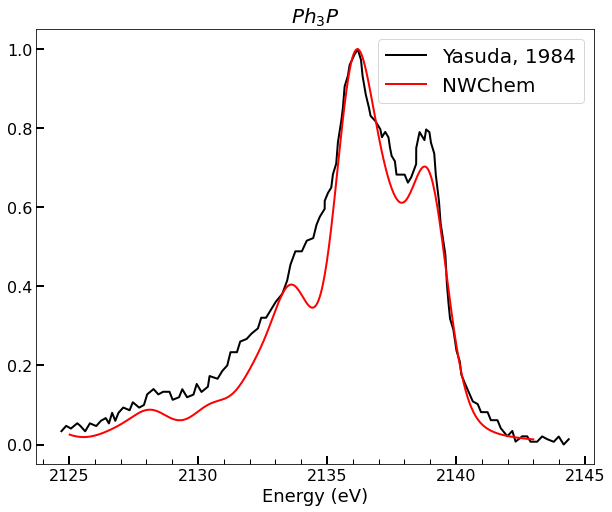

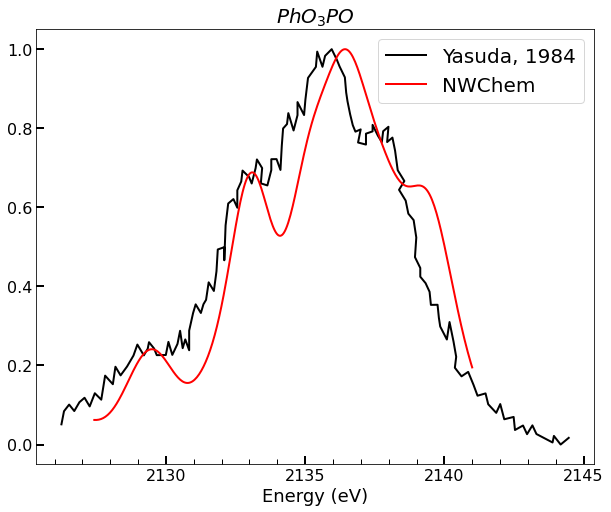

In [13]:
df1 = pd.read_csv('Ph3P.csv')
df2 = pd.read_csv('Ph3PO.csv')
df3 = pd.read_csv('PhO3PO.csv')

hc = 1.23984193e-6 #ev/m
d = 6.5327e-10 #m
def to_energy(two_theta):
    return hc/(d*np.sin(two_theta*(np.pi/180)/2))


def stack_plot(Spectrums, Labels, title=None,
               verbose=True, label=None, peaknorm=True):
    
    n = len(Spectrums)
    Colors=plt.cm.viridis(np.arange(n)/(n+1))
    if n == 2:
        Colors=['black', 'red']
    fig, ax = plt.subplots(figsize=(10,8))

    i = 0
    for spectrum in Spectrums:
        x, y = spectrum
        if peaknorm:
            y = y/np.max(y)
        ax.plot(x, y, '-', color=Colors[i], linewidth=2, label=Labels[i])
        i += 1

    if title is not None:
        plt.title(title, fontsize=20)
    plt.xlabel('Energy (eV)', fontsize=18)
    plt.tick_params(labelsize=16)

    if verbose:
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.tick_params(direction='in', width=1, length=5, which='minor')

    ax.tick_params(direction='in', width=2, length=8, which='major')

    plt.legend(fontsize=20)
    
    plt.show()

    
####################### spectrum 1
x = to_energy(df1['2theta'].values)
y = df1['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 350, 800
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[0])[0][0]
y2 = XES[i][emin:emax]
e_shift = x2[np.argmax(y2)] - x[np.argmax(y)]
stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$Ph_3P$")

####################### spectrum 2
x = to_energy(df3['2theta'].values)
y = df3['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 410, 750
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[2])[0][0]
y2 = XES[i][emin:emax]
stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$PhO_3PO$", verbose=True)

# ML and Data Science section

## All Spectra Together

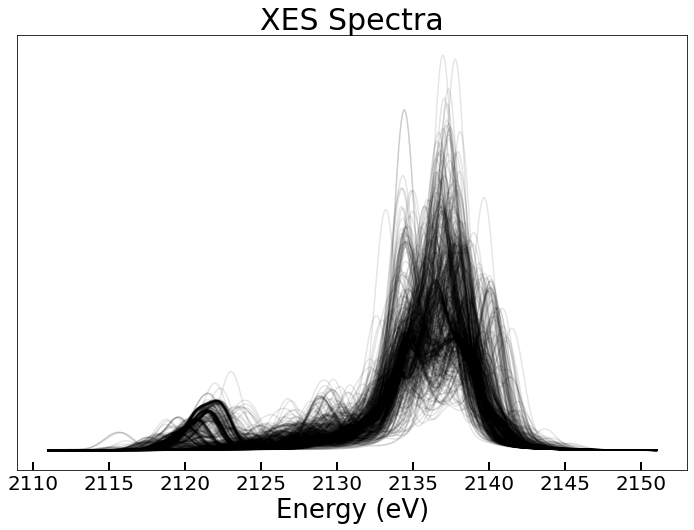

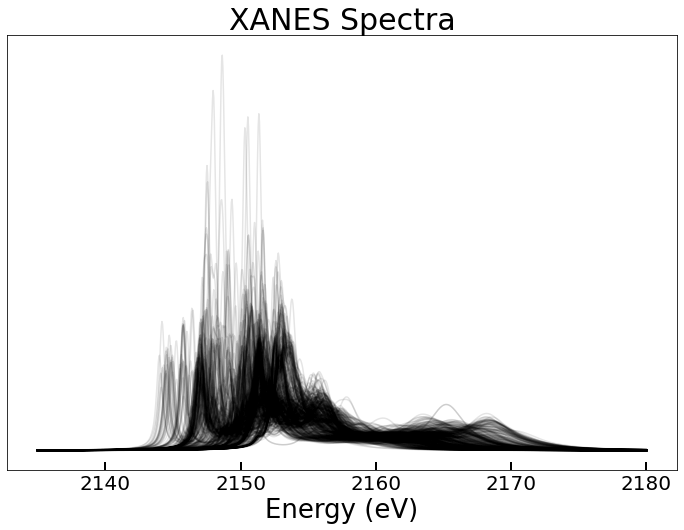

In [14]:
def Spagetti_plot(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    MIN, MAX = MINIMAX
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for x in X:
        plt.plot(energy, x, '-', c='k', alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.tick_params(direction='in', width=2, length=8)
    plt.yticks([])

    plt.show()
    
Spagetti_plot(XESenergy, XES, mode='XES')
Spagetti_plot(XANESenergy, XANES, mode='XANES')

## Rainbow Spaghetti Plot: Color and Stack by Compound Type

In [17]:
def Rainbow_spaghetti_plot_types_stack(subplot, energy, X, types, mode='VtC-XES', MINIMAX=[0,-1]):
    mn, mx = MINIMAX
    
    fig, ax = subplot
    
    lines = []
    n = max(u.TYPE_DICT.values())
    Colors = plt.cm.viridis(np.arange(n)/(n-1))
    for x,cid,moltype in zip(X,CIDS,types):
        bin_num = u.TYPE_DICT[moltype]
        lines.append(plt.plot(energy[mn:mx], x[mn:mx] + bin_num, '-', color=Colors[bin_num-1], alpha=0.1,\
                              label=(str(cid)+','+str(moltype)))[0])
        
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    ax.tick_params(direction='in', width=2, length=8)
    plt.xticks(fontsize=20)
    
    if mode == 'XANES' or mode == 'XES':
        ax.xaxis.set_minor_locator(MultipleLocator(2))
        ax.xaxis.set_major_locator(MultipleLocator(10))
    
    ax.tick_params(direction='in', width=2, length=10, which='major')
    ax.tick_params(direction='in', width=1, length=8, which='minor')
    plt.yticks([])
    
    '''
    mplcursors.cursor(lines, highlight=True, \
                      highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
                     #.connect("add", lambda sel: webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l"))
    '''
    
    plt.show()
    
    return lines

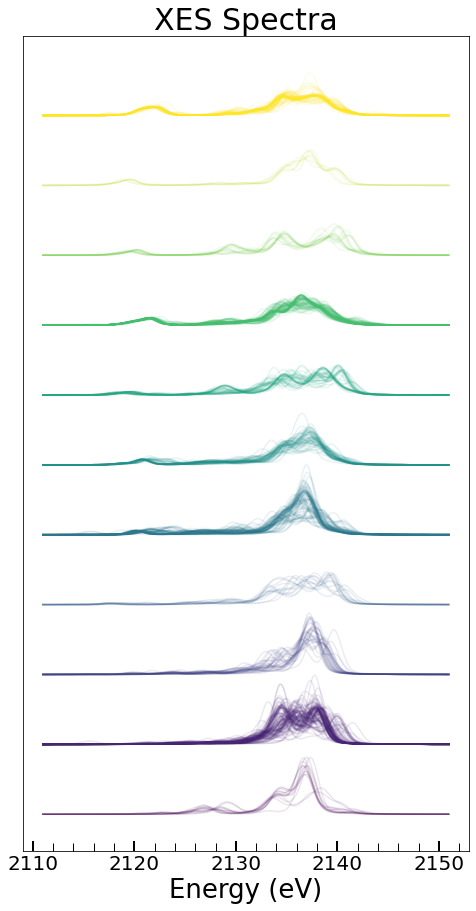

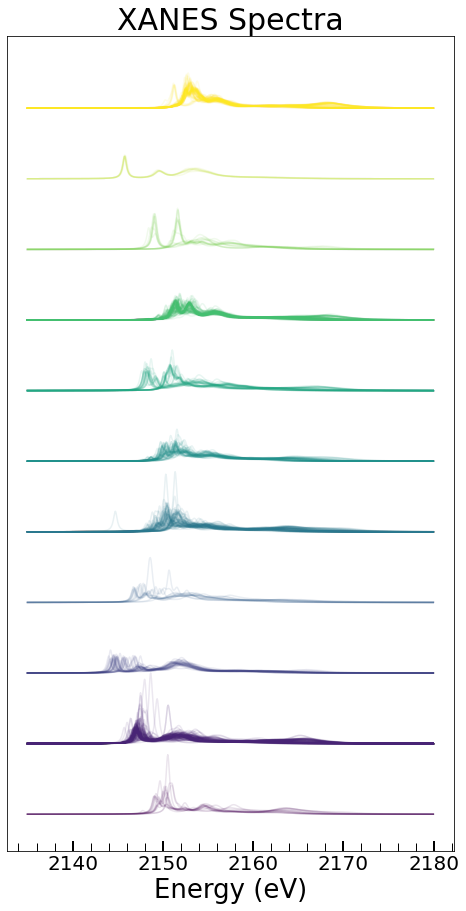

In [18]:
Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XESenergy, XES, compoundclasses, mode='XES');
Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XANESenergy, XANES, compoundclasses, mode='XANES');

## ML Reduced Space: PCA and t-SNE

In [19]:
warnings.filterwarnings("ignore")
# pca
pca1 = PCA(n_components=2)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=2)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
XANES_TSNE = tsne.fit_transform(XANES)

In [20]:
def onselect(sel):
    sel.annotation.set_text( \
    str(CIDS[sel.target.index])+','+str(compoundclasses[sel.target.index]))
    webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l")
        

def plot_dim_red(plot, X_red, types, method, fontsize=16, mode='VtC-XES'):

    fig, ax = plot
        
    '''
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    '''
    
    colors = [u.TYPE_DICT[t] for t in types]
    
    dots = plt.scatter(X_red[:, 0], X_red[:, 1], c=colors, cmap=CMAP)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
    ax.set_xlabel(f"{method} [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"{method} [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    legend = ax.legend([f'{mode}:\n{method}'], handlelength=0, handletextpad=0,
                           fancybox=True, fontsize=22)
    for item in legend.legendHandles:
        item.set_visible(False)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
        
    plt.show()
    
    return dots

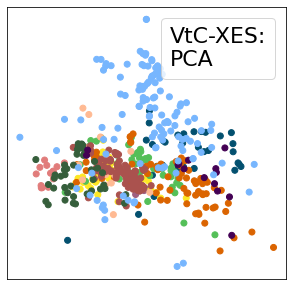

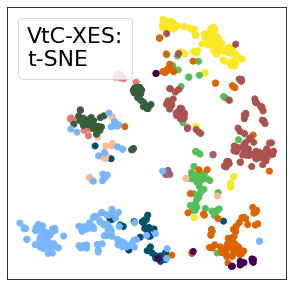

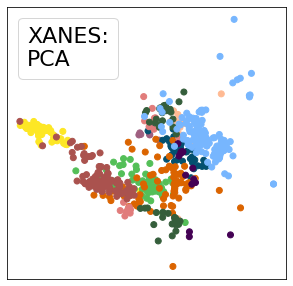

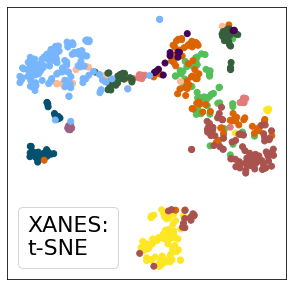

<function __main__.onselect(sel)>

In [21]:
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XES_PCA, compoundclasses, 'PCA')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XES_TSNE,compoundclasses, 't-SNE')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XANES_PCA, compoundclasses, 'PCA', mode='XANES')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XANES_TSNE, compoundclasses, 't-SNE', mode='XANES')).connect("add", onselect)

## Spectra + Reduced Space Combined

In [ ]:
%matplotlib notebook

In [ ]:
linktopubchem = True

oldlineprops = {}

def highlight_spectra(sel):
    sel.annotation.set_text( \
        str(CIDS[sel.target.index])+','+str(compoundclasses[sel.target.index]))
    if oldlineprops:
        spectra_lines[oldlineprops['index']].set_linewidth(oldlineprops['linewidth'])
        spectra_lines[oldlineprops['index']].set_color(oldlineprops['color'])
        spectra_lines[oldlineprops['index']].set_alpha(oldlineprops['alpha'])
    oldlineprops['index'] = sel.target.index
    oldlineprops['linewidth'] = spectra_lines[sel.target.index].get_lw()
    oldlineprops['color'] = spectra_lines[sel.target.index].get_c()
    oldlineprops['alpha'] = spectra_lines[sel.target.index].get_alpha()
    spectra_lines[sel.target.index].set_linewidth(3)
    spectra_lines[sel.target.index].set_color('k')
    spectra_lines[sel.target.index].set_alpha(1)
    if linktopubchem:
        webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l")

def unhighlight_spectra(sel):
    spectra_lines[sel.target.index].set_linewidth(oldlineprops['linewidth'])
    spectra_lines[sel.target.index].set_color(oldlineprops['color'])
    spectra_lines[sel.target.index].set_alpha(oldlineprops['alpha'])
        

olddotprops = {}

def highlight_dot(sel):
    #sel.annotation.set_text(str(CIDS[sel.target.index])+' '+str(types[sel.target.index]))
    if olddotprops:
        redspace_dots.set_edgecolors(olddotprops['colors'])
    olddotprops['colors'] = copy.deepcopy(redspace_dots.get_edgecolors())
    newdotedgecolors = copy.deepcopy(olddotprops['colors'])
    #webbroswer.open(str(len(olddotedgecolors)))
    #webbrowser.open(repr(sel.artist.get_label().split(',')[0]))
    index = CIDS.index(int(sel.artist.get_label().split(',')[0]))
    newdotedgecolors[index] = [1,0,0,1]
    redspace_dots.set_edgecolors(newdotedgecolors)
    if linktopubchem:
        webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[index]}&t=l")


def unhighlight_dot(sel):
    webbrowser.open('test')
    redspace_dots.set_edgecolors(olddotprops['colors'])
    
spectra_lines = Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XANESenergy, XANES, compoundclasses, mode='XANES')
redspace_dots = plot_dim_red(plt.subplots(figsize=(5,5)), XANES_TSNE, compoundclasses, 't-SNE', mode='XANES')

dotcursor = mplcursors.cursor(redspace_dots)
dotcursor.connect("add", highlight_spectra)
# dotcursor.connect("remove", unhighlight_spectra)

linecursor = mplcursors.cursor(spectra_lines, highlight=True,
                  highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
linecursor.connect("add", highlight_dot)
#linecursor.connect("remove", unhighlight_dot)

In [ ]:
# Uncomment and run the line below to stop it linking to PubChem when you click on the figures
# linktopubchem = True

In [ ]:
# spectra_lines = Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XESenergy, XES, compoundclasses, mode='XES')
# redspace_dots = plot_dim_red(plt.subplots(figsize=(5,5)), XES_TSNE, compoundclasses, 't-SNE', mode='XES')

# dotcursor = mplcursors.cursor(redspace_dots)
# dotcursor.connect("add", highlight_spectra)
# #dotcursor.connect("remove", unhighlight_spectra)

# linecursor = mplcursors.cursor(spectra_lines, highlight=True,
#                   highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
# linecursor.connect("add", highlight_dot)